# Independent Randomization Demo on Inception V3

### Before running this notebook
Make sure you have all the installed the necessary packages from the requirements.txt file.


To run this notebooks, you will need inception pretrained weights. These are available from [tensorflow](http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz). Alternatively, the weights can be obtained and decompressed as follows:

```
wget http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
tar -xvzf inception_v3_2016_08_28.tar.gz
```

In addition, make sure the files, 'imagenet_class_index.json' and 'inception_v3.ckpt' are in the models/inceptionsv3.

In [1]:
from __future__ import absolute_import, division, print_function

%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

import tensorflow as tf
import seaborn as sns
import saliency
import pickle
import PIL
import json

# urllib python2 v. python3 hack.
if sys.version_info[0] == 3:
    from urllib.request import urlopen
else:
    from urllib import urlopen

import keras 
from matplotlib import gridspec
import seaborn as sns

from scipy.stats import spearmanr as spr
from scipy.stats import pearsonr
import pandas as pd
from skimage.measure import compare_ssim as ssim
from skimage import feature
slim=tf.contrib.slim

from src.inception_v3 import inception_v3_arg_scope
from src.inception_v3 import inception_v3

# some plotting defaults
%matplotlib inline
sns.set_style('whitegrid', {'axes.grid': False})
SSIZE=10
MSIZE=12
BSIZE=14
plt.rc('font', size=SSIZE)
plt.rc('axes', titlesize=MSIZE)
plt.rc('axes', labelsize=MSIZE)
plt.rc('xtick', labelsize=MSIZE)
plt.rc('ytick', labelsize=MSIZE)
plt.rc('legend', fontsize=MSIZE)
plt.rc('figure', titlesize=MSIZE)
plt.rcParams['font.family'] = "sans-serif"

Using TensorFlow backend.
W1108 17:18:00.683767 139959609407232 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1108 17:18:00.685956 139959609407232 deprecation_wrapper.py:119] From ../src/inception_v3.py:39: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.



In [2]:
def abs_grayscale_norm(img):
    """Returns absolute value normalized image 2D."""
    assert isinstance(img, np.ndarray), "img should be a numpy array"
    
    shp = img.shape
    if len(shp)< 2:
        raise ValueError("Array should have 2 or 3 dims!")
    if len(shp)==2:
        img = np.absolute(img)
        img = img/float(img.max())
    else:
        img = saliency.VisualizeImageGrayscale(img)
    return img
def diverging_norm(img):
    """Returns image with positive and negative values."""
    assert isinstance(img, np.ndarray), "img should be a numpy array"
    
    shp = img.shape
    if len(shp)< 2:
        raise ValueError("Array should have 2 or 3 dims!")
    if len(shp)==2:
        imgmax = np.absolute(img).max()
        img = img/float(imgmax)
    else:
        img = saliency.VisualizeImageDiverging(img)
    return img

def plot_single_img(img,
                    ax=False,
                    norm=diverging_norm,
                    show_axis=False,
                    grayscale=False,
                    cmap='gray',
                    title='',
                    fig_size=(4,4)):
    plt.figure(figsize=fig_size)
    if norm:
        img = norm(img)
    if not show_axis:
        plt.axis('off')
    plt.imshow(img, cmap=cmap)
    if title:
        plt.title(title)

def LoadImage(file_path, resize=True, sztple=(299, 299)):
    img = PIL.Image.open(file_path).convert('RGB')
    if resize:
        img = img.resize(sztple, PIL.Image.ANTIALIAS)
    img = np.asarray(img)
    return img / 127.5 - 1.0

def ShowImage(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    im = ((im + 1) * 127.5).astype(np.uint8)
    plt.imshow(im)
    plt.title(title)
    
def normalize_image(x):
    x = np.array(x).astype(np.float32)
    x_min = x.min()
    x_max = x.max()
    x_norm = (x - x_min) / (x_max - x_min)
    return x_norm

In [3]:
def get_saliency_constructors(model_graph,
                              model_session,
                              logit_tensor,
                              input_tensor,
                              gradcam=False,
                              conv_layer_gradcam=None):
    """Initialize mask functions in saliency package.

    Args:
        model_graph: tf graph of the model.
        model_session: tf session with trained model loaded.
        logit_tensor: tensor corresponding to the model logit output.
        input_tensor: tensor coresponding to the input data.
        gradcam: boolean to indicate whether to include gradcam.
        conv_layer_gradcam: tensor corresponding to activations
                            from a conv layer, from the trained model.
                            Authors recommend last layer.
    Returns:
        saliency_constructor: dictionary (name of method, and value is
                              function to each saliency method.
        neuron_selector: tensor of specific output to explain.
    """

    assert (type(tf.Graph()) == type(model_graph)),\
        ("Model graph should be of type {}".format(type(tf.Graph())))

    if gradcam and conv_layer_gradcam is None:
        raise ValueError("If gradcam is True, then conv_layer_gradcam"
                         "is be provided.")
    with model_graph.as_default():
        with tf.name_scope("saliency"):
            neuron_selector = tf.placeholder(tf.int32)
            y_salient = logit_tensor[neuron_selector]
    gradient_saliency = saliency.GradientSaliency(model_graph,
                                                  model_session,
                                                  y_salient,
                                                  input_tensor)
    guided_backprop = saliency.GuidedBackprop(model_graph,
                                              model_session,
                                              y_salient,
                                              input_tensor)
    integrated_gradients = saliency.IntegratedGradients(model_graph,
                                                        model_session,
                                                        y_salient,
                                                        input_tensor)
    saliency_constructor = {'vng': gradient_saliency,
                            'gbp': guided_backprop,
                            'ig': integrated_gradients}
    if gradcam:
        gradcam = saliency.GradCam(model_graph,
                                   model_session,
                                   y_salient,
                                   input_tensor,
                                   conv_layer_gradcam)
        saliency_constructor['gc'] = gradcam
    return saliency_constructor, neuron_selector

class Inceptionv3_Wrapper(object):
    def __init__(self, checkpointpath, labelmetadatapath):
        tf.reset_default_graph()
        self.graph = tf.Graph()
        self.chkpntpath = checkpointpath
        self.labelmetadatapath = labelmetadatapath
        self.num_classes = 1001 # 0 is background or null class
        self.label_dict = {}
        
        if not tf.io.gfile.exists(self.chkpntpath):
            raise ValueError("There is no checkpoint at the input path")
        with self.graph.as_default():
            self.input_batch = tf.placeholder(tf.float32,
                                          shape=(None, 299, 299, 3))
            with slim.arg_scope(inception_v3_arg_scope()):
                _, self.end_points = inception_v3(
                  self.input_batch,
                  is_training=False,
                  num_classes=self.num_classes)
                self.session = tf.Session(graph=self.graph)
                self.saver = tf.train.Saver()
                self.saver.restore(self.session, self.chkpntpath)
                
            self.logits = self.graph.get_tensor_by_name(
                'InceptionV3/Logits/SpatialSqueeze:0')
            self.trainable_variables = tf.trainable_variables()
        
        if not tf.io.gfile.exists(self.labelmetadatapath):
            raise ValueError("There is no label file at the input path.")
        
        # process labels in appropriate dictionary
        with open(self.labelmetadatapath) as json_file:
            data = json.load(json_file)
            shift = 0
            if self.num_classes == 1001:
                self.label_dict = {0: ["background", "background"]}
                shift = 1
            for key in data:
                self.label_dict[int(key)+shift] = data[key] 
        
    def predict(self, batch):
        if not isinstance(batch, (np.ndarray)):
            raise ValueError("input should be a numpy array!")
        
        if len(batch.shape) < 4:
            raise ValueError(
              "Shape should be (nsamples, height, width, channels)")
        
        feed_dict = {self.input_batch: batch}
        logits = self.session.run(self.logits,
                                  feed_dict = feed_dict)
        return logits
    
    def reinitlayerlist(self, blocklist, independent=False):
        """Reinitialize Tensors with these names."""
        if independent:
            self.__init__()
        tensors = []
        for op in self.trainable_variables:
            for blockname in blocklist:
                if blockname in op.name:
                    tensors.append(op)
                    
        # now reinitialize
        with self.graph.as_default():
            to_ini = tf.initialize_variables(tensors)
            _ = self.session.run(to_ini)
        return True
        
    def indextoclsnames(self, arr, topk=5):
        """Given a numpy vector, get label names for topk."""
        names = []
        topk_indices = arr.argsort()[::-1][:topk]
        for val in topk_indices:
            names.append(self.label_dict[val][1])
        return names

In [4]:
cwd = os.getcwd()
imagenetlabeljsonpath = '../models/inceptionv3/imagenet_class_index.json'
chkpntpath = '../models/inceptionv3/inception_v3.ckpt'
chkpntpath = os.path.join(cwd, chkpntpath)
imagenetlabeljsonpath = os.path.join(cwd, imagenetlabeljsonpath)
if not os.path.exists(chkpntpath):
    raise ValueError("Checkpoint path does not exist!")
if not os.path.exists(imagenetlabeljsonpath):
    raise ValueError("Label json path does not exist!")

# Load model and make predictions

W1108 17:18:00.778950 139959609407232 deprecation_wrapper.py:119] From ../src/inception_v3.py:528: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W1108 17:18:07.790568 139959609407232 deprecation.py:323] From /home/julius/virtualenvs/sanity_checks/lib/python3.5/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


(4, 299, 299, 3)


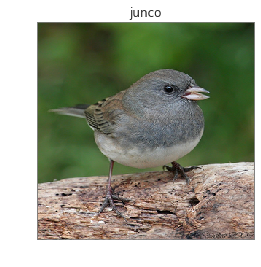

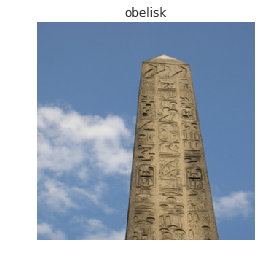

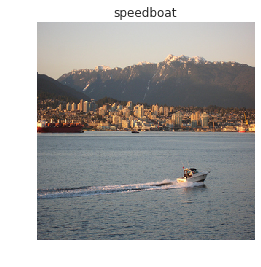

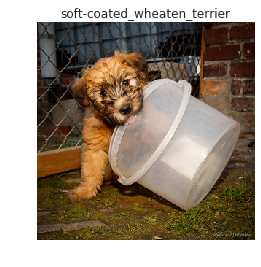

In [5]:
inception_model = Inceptionv3_Wrapper(chkpntpath, imagenetlabeljsonpath)

# Get bird image
basepath = '../data/demo_images/'
# assemble a list of these images
listfiles =  tf.io.gfile.listdir(basepath)
demo_batch = []
for fl in listfiles:
    demo_batch.append(LoadImage(basepath+fl, resize=True))
demo_batch = np.array(demo_batch)
demo_batch = demo_batch[:4]
print(demo_batch.shape)

# model predictions for these images
logits = inception_model.predict(demo_batch)
for i in range(logits.shape[0]):
    title = inception_model.indextoclsnames(logits[i], topk=1)[0]
    ShowImage(demo_batch[i], title=title)

# Let's compute attributions

In [6]:
# set up saliency computations.
saliency_dict, n_selector = get_saliency_constructors(inception_model.graph,
                                                      inception_model.session,
                                                      inception_model.logits[0],
                                                      inception_model.input_batch,
                                                      gradcam=True,
                                                      conv_layer_gradcam=inception_model.end_points['Mixed_7c'])

# these are the methods we will look at
saliency_methods = {'Gradient': saliency_dict['vng'].GetMask,
                    'SmoothGrad': saliency_dict['vng'].GetSmoothedMask,
                    'Guided\nBackProp': saliency_dict['gbp'].GetMask,
                    'Integrated\nGradients': saliency_dict['ig'].GetMask,
                    'IG\nSmoothGrad': saliency_dict['ig'].GetSmoothedMask,
                    'GradCAM': saliency_dict['gc'].GetMask}

# list of aggregate dictionary of masks.
# each image attribution will be a dictionary, where key=methods and value
# is the attribution numpy array. 
list_of_masks = []
for i, current_image in enumerate(demo_batch):
    print("On image {}".format(i))
    # zero baseline for integrated gradients
    baseline = np.zeros(current_image.shape)
    # prediction.
    imglogits = inception_model.session.run(
        [inception_model.logits],
        feed_dict={inception_model.input_batch: np.expand_dims(current_image, 0)})[0]
    
    prediction_class = imglogits.argmax() # compute saliency for top class.
    gen_feed_dict = {n_selector: prediction_class}
    
    # set up params for each saliency method
    saliency_params = {'Gradient': {"feed_dict": gen_feed_dict},
                       'SmoothGrad': {"feed_dict": gen_feed_dict,
                                      "stdev_spread":0.15,
                                      "nsamples":50,
                                      "magnitude":False},
                       'Guided\nBackProp': {"feed_dict": gen_feed_dict},
                       'Integrated\nGradients': {"feed_dict": gen_feed_dict,
                                                 "x_steps":50,
                                                 "x_baseline":baseline},
                       'IG\nSmoothGrad': {"feed_dict": gen_feed_dict,
                                          "x_steps":50,
                                          "stdev_spread": 0.15,
                                          "x_baseline":baseline,
                                          "magnitude":False},
                       'GradCAM':{"feed_dict": gen_feed_dict,
                                  "three_dims": True}}    
    
    output_masks = {}
    for key in saliency_methods:
        print("On {}".format(key))
        params = saliency_params[key]
        output_masks[key] = saliency_methods[key](current_image,**params)
    # compute some other methods
    # input-gradient and guided-gradcam
    output_masks["Input-Grad"] = np.multiply(output_masks['Gradient'], current_image)
    output_masks["GBP-GC"] = np.multiply(output_masks['Guided\nBackProp'], output_masks['GradCAM'])
    list_of_masks.append(output_masks)

W1108 17:18:12.637477 139959609407232 deprecation_wrapper.py:119] From /home/julius/virtualenvs/sanity_checks/lib/python3.5/site-packages/saliency/guided_backprop.py:49: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.

W1108 17:18:15.425209 139959609407232 deprecation_wrapper.py:119] From /home/julius/virtualenvs/sanity_checks/lib/python3.5/site-packages/saliency/guided_backprop.py:56: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



On image 0
On SmoothGrad
On Guided
BackProp
On GradCAM


W1108 17:18:45.303457 139959609407232 deprecation_wrapper.py:119] From /home/julius/virtualenvs/sanity_checks/lib/python3.5/site-packages/saliency/grad_cam.py:77: The name tf.image.resize_bilinear is deprecated. Please use tf.compat.v1.image.resize_bilinear instead.



On Integrated
Gradients
On Gradient
On IG
SmoothGrad
On image 1
On SmoothGrad
On Guided
BackProp
On GradCAM
On Integrated
Gradients
On Gradient
On IG
SmoothGrad
On image 2
On SmoothGrad
On Guided
BackProp
On GradCAM
On Integrated
Gradients
On Gradient
On IG
SmoothGrad
On image 3
On SmoothGrad
On Guided
BackProp
On GradCAM
On Integrated
Gradients
On Gradient
On IG
SmoothGrad


In [7]:
# We are now doing normalization of the different attributions
# normalize by absolute values
list_of_masks_abs_norm = []

# normalize but keep the signs
list_of_masks_no_abs_norm = []
list_of_masks_0_1_norm = []

for i, img_dict in enumerate(list_of_masks):
    new_dict_abs_norm = {}
    new_dict_no_abs_norm = {}
    new_dict_0_1_norm = {}
    for key in img_dict:
        mask = img_dict[key]
        mask_abs_norm = abs_grayscale_norm(mask)
        mask_no_abs_norm = diverging_norm(mask)
        mask_0_1_norm = normalize_image(mask)
        new_dict_abs_norm[key] = mask_abs_norm
        new_dict_no_abs_norm[key] = mask_no_abs_norm
        new_dict_0_1_norm[key] =mask_0_1_norm
    list_of_masks_abs_norm.append(new_dict_abs_norm)
    list_of_masks_no_abs_norm.append(new_dict_no_abs_norm)
    list_of_masks_0_1_norm.append(new_dict_0_1_norm)

# Let's do independent randomization of 3 blocks

Here we will randomize in 3 blocks stages: top layer (Logits), 'mixed_5b' block, and conv2d_1a.

To clarify: we reintialize every trainable variable including biases and bactch-norm parameters for each 'block' that we reinitialize

In [8]:
master_independent_randomization_dictionary = {}
layer_randomization_order = ['InceptionV3/Logits', 'InceptionV3/Mixed_5b',
                             'InceptionV3/Conv2d_1a_3x3']
# begin randomization
for i, layer_name in enumerate(layer_randomization_order):
    print("Cascading reinitialization up to on layer {}".format(layer_name))
    
    # list of parameters to be reintialized
    layer_list = [layer_name]
    
    # load a new inception v3 model.
    inception_model = Inceptionv3_Wrapper(chkpntpath, imagenetlabeljsonpath)
    
    # reinitialize all trainable ops up to that layer.
    inception_model.reinitlayerlist(layer_list)
    
    # set up saliency computations.
    saliency_dict, n_selector = get_saliency_constructors(inception_model.graph,
                                                          inception_model.session,
                                                          inception_model.logits[0],
                                                          inception_model.input_batch,
                                                          gradcam=True,
                                                          conv_layer_gradcam=inception_model.end_points['Mixed_7c'])

    # these are the methods we will look at
    saliency_methods = {'Gradient': saliency_dict['vng'].GetMask,
                        'SmoothGrad': saliency_dict['vng'].GetSmoothedMask,
                        'Guided\nBackProp': saliency_dict['gbp'].GetMask,
                        'Integrated\nGradients': saliency_dict['ig'].GetMask,
                        'IG\nSmoothGrad': saliency_dict['ig'].GetSmoothedMask,
                        'GradCAM': saliency_dict['gc'].GetMask}
    
    # list to store collection of images
    list_of_random_mask_per_layer = []
    for j, current_image in enumerate(demo_batch):
        # print(i)
        baseline = np.zeros(current_image.shape)
        imglogits = inception_model.session.run(
            [inception_model.logits],
            feed_dict={inception_model.input_batch: np.expand_dims(current_image, 0)})[0]
        
        prediction_class = imglogits.argmax() # this the output to explain.
        gen_feed_dict = {n_selector: prediction_class}

        # set up params for each saliency method
            # set up params for each saliency method
        saliency_params = {'Gradient': {"feed_dict": gen_feed_dict},
                           'SmoothGrad': {"feed_dict": gen_feed_dict,
                                          "stdev_spread":0.15,
                                          "nsamples":50,
                                          "magnitude":False},
                           'Guided\nBackProp': {"feed_dict": gen_feed_dict},
                           'Integrated\nGradients': {"feed_dict": gen_feed_dict,
                                                     "x_steps":50,
                                                     "x_baseline":baseline},
                           'IG\nSmoothGrad': {"feed_dict": gen_feed_dict,
                                              "x_steps":50,
                                              "stdev_spread": 0.15,
                                              "x_baseline":baseline,
                                              "magnitude":False},
                           'GradCAM':{"feed_dict": gen_feed_dict,
                                      "three_dims": True}} 
        output_masks = {}
        for key in saliency_methods:
            # print("On {}".format(key))
            params = saliency_params[key]
            output_masks[key] = saliency_methods[key](current_image,**params)
        # compute some other methods
        # input-gradient and guided-gradcam
        output_masks["Input-Grad"] = np.multiply(output_masks['Gradient'], current_image)
        output_masks["GBP-GC"] = np.multiply(output_masks['Guided\nBackProp'], output_masks['GradCAM'])
        list_of_random_mask_per_layer.append(output_masks)
        # now add the list of random masks to the dictionary
    master_independent_randomization_dictionary[layer_name] = list_of_random_mask_per_layer

Cascading reinitialization up to on layer InceptionV3/Logits


W1108 17:51:56.612766 139959609407232 deprecation.py:323] From /home/julius/virtualenvs/sanity_checks/lib/python3.5/site-packages/tensorflow/python/util/tf_should_use.py:193: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.


Cascading reinitialization up to on layer InceptionV3/Mixed_5b
Cascading reinitialization up to on layer InceptionV3/Conv2d_1a_3x3


In [9]:
master_independent_randomization_dictionary_abs_norm = {}
master_independent_randomization_dictionary_no_abs_norm = {}
master_independent_randomization_dictionary_0_1_norm = {}

for layer in master_independent_randomization_dictionary:
    mask_list_abs_norm = []
    mask_list_no_abs_norm = []
    mask_list_0_1_norm = []
    for i, mask_dict in enumerate(master_independent_randomization_dictionary[layer]):
    # first append original image
        new_dict_abs_norm = {}
        new_dict_no_abs_norm = {}
        new_dict_0_1_norm = {}
        for key in mask_dict:
            mask = mask_dict[key]
            
            mask_abs_norm = abs_grayscale_norm(mask)
            mask_no_abs_norm = diverging_norm(mask)
            mask_0_1_norm = normalize_image(mask)
            
            new_dict_abs_norm[key] = mask_abs_norm
            new_dict_no_abs_norm[key] = mask_no_abs_norm
            new_dict_0_1_norm[key] = mask_0_1_norm
            
        mask_list_abs_norm.append(new_dict_abs_norm)
        mask_list_no_abs_norm.append(new_dict_no_abs_norm)
        mask_list_0_1_norm.append(new_dict_0_1_norm)
    master_independent_randomization_dictionary_abs_norm[layer] = mask_list_abs_norm
    master_independent_randomization_dictionary_no_abs_norm[layer] = mask_list_no_abs_norm
    master_independent_randomization_dictionary_0_1_norm[layer] = mask_list_0_1_norm

In [10]:
for key in master_independent_randomization_dictionary:
    assert len(master_independent_randomization_dictionary[key])==len(master_independent_randomization_dictionary_no_abs_norm[key])
    for i, item in enumerate(master_independent_randomization_dictionary[key]):
        assert len(item)==len(master_independent_randomization_dictionary_no_abs_norm[key][i])
for key in master_independent_randomization_dictionary:
    assert len(master_independent_randomization_dictionary[key])==len(master_independent_randomization_dictionary_abs_norm[key])
    for i, item in enumerate(master_independent_randomization_dictionary[key]):
        assert len(item)==len(master_independent_randomization_dictionary_abs_norm[key][i])
for key in master_independent_randomization_dictionary:
    assert len(master_independent_randomization_dictionary[key])==len(master_independent_randomization_dictionary_0_1_norm[key])
    for i, item in enumerate(master_independent_randomization_dictionary[key]):
        assert len(item)==len(master_independent_randomization_dictionary_0_1_norm[key][i])

In [11]:
independent_master_plotting_list_abs_norm = []
independent_master_plotting_list_no_abs_norm = []

index_to_input_to_plot = 3 # this must be less than the len of demo_batch

mask_order = ["Gradient", "SmoothGrad","Input-Grad", "Guided\nBackProp",\
              "GradCAM", "GBP-GC", "Integrated\nGradients", "IG\nSmoothGrad"]
for method in mask_order:
    # first insert normal saliency method
    normal_mask_abs_norm = list_of_masks_abs_norm[index_to_input_to_plot][method]
    normal_mask_no_abs_norm = list_of_masks_no_abs_norm[index_to_input_to_plot][method]
    independent_master_plotting_list_abs_norm.append(normal_mask_abs_norm)
    independent_master_plotting_list_no_abs_norm.append(normal_mask_no_abs_norm)
    for layer in layer_randomization_order:
        mask_abs_norm =  master_independent_randomization_dictionary_abs_norm[layer][index_to_input_to_plot][method]
        independent_master_plotting_list_abs_norm.append(mask_abs_norm)
        
        mask_no_abs_norm =  master_independent_randomization_dictionary_no_abs_norm[layer][index_to_input_to_plot][method]
        independent_master_plotting_list_no_abs_norm.append(mask_no_abs_norm)

In [12]:
print(len(independent_master_plotting_list_abs_norm))
print(len(independent_master_plotting_list_no_abs_norm))

32
32


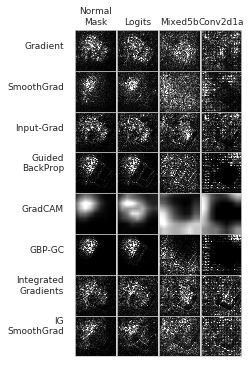

In [13]:
layer_number = 3
ncols = layer_number + 1
nrows = len(mask_order)
    
fig = plt.figure(figsize=(3,6))
gs = gridspec.GridSpec(nrows, ncols,
                       wspace=0.0, hspace=0.0)
cmap='gray'
count = 0
titles = ["Gradient", "SmoothGrad","Input-Grad", "Guided\nBackProp",\
              "GradCAM", "GBP-GC", "Integrated\nGradients", "IG\nSmoothGrad"]
new_layer_names = ['Normal\nMask', 'Logits', "Mixed5b", 'Conv2d1a']
for i in range(nrows):
    for j in range(ncols):
        ax = plt.subplot(gs[i, j])
        ax.imshow(independent_master_plotting_list_abs_norm[count],
                  vmin=0.0,
                  vmax=1.0,
                  cmap=cmap)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
            
        # add labels
        if count < 4:
            ax.set_title(new_layer_names[count], fontsize=9)
            
        # increment count
        count +=1
            
        if ax.is_first_col():
            ax.set_ylabel(titles[i], fontsize=9,rotation='horizontal', ha='right')
plt.show()

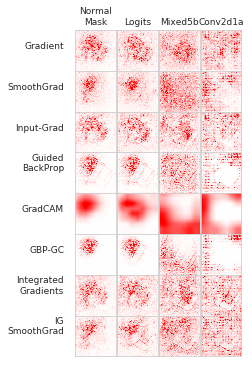

In [14]:
layer_number = 3
ncols = layer_number + 1
nrows = len(mask_order)
    
fig = plt.figure(figsize=(3,6))
gs = gridspec.GridSpec(nrows, ncols,
                       wspace=0.0, hspace=0.0)
cmap='bwr'
count = 0
titles = ["Gradient", "SmoothGrad","Input-Grad", "Guided\nBackProp",\
              "GradCAM", "GBP-GC", "Integrated\nGradients", "IG\nSmoothGrad"]
new_layer_names = ['Normal\nMask', 'Logits', "Mixed5b", 'Conv2d1a']
for i in range(nrows):
    for j in range(ncols):
        ax = plt.subplot(gs[i, j])
        ax.imshow(independent_master_plotting_list_abs_norm[count],
                  vmin=-1.0,
                  vmax=1.0,
                  cmap=cmap)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
            
        # add labels
        if count < 4:
            ax.set_title(new_layer_names[count], fontsize=9)
            
        # increment count
        count +=1
            
        if ax.is_first_col():
            ax.set_ylabel(titles[i], fontsize=9,rotation='horizontal', ha='right')
plt.show()

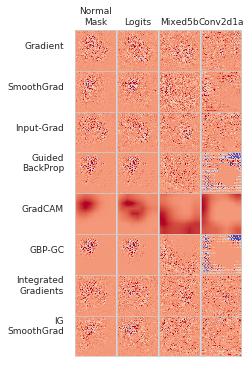

In [15]:
fig = plt.figure(figsize=(3,6))
gs = gridspec.GridSpec(nrows, ncols,
                       wspace=0.0, hspace=0.0)
cmap='coolwarm'
count = 0
titles = ["Gradient", "SmoothGrad","Input-Grad", "Guided\nBackProp",\
              "GradCAM", "GBP-GC", "Integrated\nGradients", "IG\nSmoothGrad"]
new_layer_names = ['Normal\nMask', 'Logits', "Mixed5b", 'Conv2d1a']
for i in range(nrows):
    for j in range(ncols):
        ax = plt.subplot(gs[i, j])
        ax.imshow(independent_master_plotting_list_no_abs_norm[count],
                  vmin=-1.0,
                  vmax=1.0,
                  cmap=cmap)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
            
        # add labels
        if count < 4:
            ax.set_title(new_layer_names[count], fontsize=9)
            
        # increment count
        count +=1
            
        if ax.is_first_col():
            ax.set_ylabel(titles[i], fontsize=9,rotation='horizontal', ha='right')
plt.show()